# INFO 2950 Final Project Phase IV
Mary Kolbas (mck86)  
Tammy Zhang (tz332)  


## Introduction

_What is the context of the work? What research question are you trying to answer? What are your main findings? Include a brief summary of your results._

Our project investigates observations of avian species at birdfeeders across North America in the winter of 2020 through the spring of 2021. The datasets behind our analysis are all provided by the Cornell Lab of Ornithology's [Project FeederWatch](https://feederwatch.org/about/project-overview/), an extensive citizen-science-based data source that annually engages US-Canada residents in a November-April survey to collect data on the birds that people see at the feeders in their backyards. In this survey, Project FeederWatch asks observers to take note of the species they notice and how many are present, as well as allowing users to input information on their backyard's characteristics; this includes what kind of habitats are present and other environmental/ambient factors. Of these numerous factors, we decided to focus on local housing density (categorized as "rural", "suburban/rural", "suburban", and "urban") as a key variable of interest relative to the species and counts observed.



### Research Question
Our general research question is divided into two main parts as follows.

**How does local housing density influence the distribution of avian species commonly observed at backyard feeders, on both a broad continental scale and on a smaller New York specific scale?**
- Part A: Is North American bird species diversity at backyard feeders independent of housing density in the immediate area?
- Part B: Do taxonomic groups in New York that share biological characteristics (like lifestyle and preferred diet/habitat) also display marked preferences for feeders with different housing densities, or are they observed at constant rates across backyards with different housing densities?


### Main Findings and Result Summary

For Research Question Part A, we discovered that there is in fact some association between US-Canada avian species diversity and a feeder's local housing density. This relationship can be approximately modeled with a linear regression $ y = 0.291 - 0.013x_1 - 0.024x_2 - 0.126x_3 $ where y represents the proportion of the total species for a region being found in a housing-density-specific area and where the baseline condition is a feeder in a rural area. Each x represents a housing density level ($x_1$ = suburban/rural, $x_2$ = suburban, and $x_3$ = urban). The overall trend suggested by our findings is that species diversity for a region (i.e. a U.S. state) decreases on average with increasing housing density (more urban areas tend to have fewer species observed at feeders).

For Research Question Part B, we focused on two main taxonomic groups that are among the most commonly observed at backyard feeders - _Accipiter_ (soaring birds of prey such as hawks) and _Junco_ (small sparrows). We surprisingly discovered that there was no statistically significant preferences for either genus among habitats with particular housing densities, even after adjusting for the different levels of total observations taking place across different areas.

Overall, we discovered that while there may exist a relationship between overall avian species diversity at backyard feeders and the local housing density the feeder is found in, the breakdown between how different taxonomic groups may preferentially associate with different housing densities is less clear. We attribute this difficulty to some of the statistical problems inherent to presence-only data such as those provided by Project FeederWatch as well as the sheer scale of the number of species included in the datasets, which are discussed in greater detail later on.

## Data Description

Our data in `df` comprises of observations (rows) of bird sightings in NY state between November 2020 and April 2021. It has attributes (columns) of the following: 
- `loc_id`: Unique identifier for each survey site
- `subnational1_code`: Country abbreviation and State or Province abbreviation of each survey site. 
- `Month`: Month of 1st day of two-day sighting
- `Day`: Month of 1st day of two-day sighting
- `Year`: Year of 1st day of two-day sighting
- `species_code`: Bird species observed, stored as 6-letter species codes
- `how_many`: Maximum number of individuals seen at one time during observation period
- `valid`: Validity of each observation based on flagging system
- `day1_am`: binary indicating if observer watched during morning of count Day 1
- `day1_pm`: binary indicating if observer watched during afternoon of count Day 1
- `day2_am`: binary indicating if observer watched during morning of count Day 2
- `day2_pm`: binary indicating if observer watched during afternoon of count Day 2
- `snow_dep_atleast`: Participant estimate of minimum snow depth


In our case, we have constrained our data to only look at entries from NY state (`subnational1_code` = "US-NY") and are valid (`valid` = 1). 

Our data from `species_translate_df` contains a species translation table provided by FeederWatch. The most relevant columns are as follows:
- `species_code`: variable storing a 6 letter string representing a species code
- `american_english_name`: variable storing a string representing the full common name of the species in English

We use `species_translate_df` in an inner join during Data Cleaning to create `df`.

In [ ]:
species_translate_df.head()

In [ ]:
df.head()

Our data in `join_df` comprises of observations (rows) of bird sightings in NY state between November 2020 and April 2021 from `df`, with additional columns from `sites_df`, which has attributes regarding location/environment details based on a unique location id. This dataframe has new additional attributes (columns) of the following: 


- `proj_period_id`: Calendar year of end of FeederWatch season
- `yard_type_pavement`: binary variable whether location is pavement (no vegetation)
- `yard_type_garden`: binary variable whether location is a garden/courtyard 
- `yard_type_landsca`: binary variable whether location is a landscaped yard
- `yard_type_woods`: binary variable whether location is natural vegetation
- `yard_type_desert`: binary variable whether location is a natural or landscaped desert
- `hab_dcid_woods`: binary variable whether location is within 0.5mi from deciduous woods
- `hab_evgr_woods`: binary variable whether location is within 0.5mi from evergreen woods
- `hab_dcid_woods`: binary variable whether location is within 0.5mi from deciduous woods
- `hab_mixed_woods`: binary variable whether location is within 0.5mi from mixed deciduous-evergreen woods
- `hab_orchard`: binary variable whether location is within 0.5mi from an orchard
- `hab_park`: binary variable whether location is within 0.5mi from a park
- `hab_water_fresh`: binary variable whether location is within 0.5mi from fresh water
- `hab_water_salt`: binary variable whether location is within 0.5mi from salt water
- `hab_residential`: binary variable whether location is within 0.5mi from a residential area
- `hab_industrial`: binary variable whether location is within 0.5mi from an industrial or commercial area
- `hab_agricultural`: binary variable whether location is within 0.5mi from an agricultural fields
- `hab_desert_scrub`: binary variable whether location is within 0.5mi from a desert or scrub
- `hab_young_woods`: binary variable whether location is within 0.5mi from an secondary growth woods
- `hab_swamp`: binary variable whether location is within 0.5mi from a swamp (wooded)
- `hab_marsh`: binary variable whether location is within 0.5mi from a marsh
- `brsh_piles_atleast`: Minimum number of brush piles within the count area
- `water_srcs_atleast`: Minimum number of water sources within the count area
- `bird_baths_atleast`: Minimum number of bird baths within the count area
- `nearby_feeders`: binary variable whether other feeders (aside from those maintained by participant) within 90m of the count site
- `squirrels`: binary variable whether squirrels take food from the feeders at least 3 times a week
- `cats`: binary variable whether cats are active within 30m of the feeder for at least 30 min 3 times a week
- `dogs`: binary variable whether dogs are active within 30m of the feeder for at least 30 min 3 times a week
- `humans`: binary variable whether humans are active within 30m of the feeder for at least 30 min 3 times a week
- `housing_density`: Participant-defined description of the housing density of the neighborhood, where 1 = "rural", 2 = "rural/suburban", 3 = "suburban", 4 = "urban"
- `population_atleast`: categorical variable expressing participant estimated population of city or town

In [ ]:
join_df.head()

This dataset was created by Project FeederWatch for researchers seeking to conduct formal analyses, but also to have this data be freely accessible to students, journalists, and the general public. The data is collected by contributors and participants. It is created and supported by Cornell Lab and Birds Canada. Since 2016, Project FeederWatch has been sponsored by Wild Bird Unlimited and the National Science Foundation.

Because this is community-curated data, there are many processes that may have influenced what data was observed/recorded and what was not, including mislogging information. This dataset involved a validity checker that flags odd sightings and has them checked by a reviewer. The data we will be using for this project drops invalid observations. FeederWatch also notes there may be mislogged locations in `subnational1_code` represented "XX" locations, which we dropped when choosing to only look at NY state data. 

Because this is community-currated data, there is also volunteer bias in observations, as certain locations or species may be more common in the dataset due to active and dedicated users. However, many users are also very knowledgeable about birds, and therefore can provide a lot of information and identification resources. 

Preprocessing was done to change the very large dataset into a smaller, more manageable one with relevant columns. We filtered the data, dropped irrelevant columns, and added columns to bin data or aid in time series analysis. Details on the Data Cleaning process can be found in the appendix. 

Our raw datasource can be found [here](https://cornell.box.com/s/wzdfg3lotvqr6wc5ik680jzit8fu3t7s) via Cornell Box, or on the [FeederWatch Website](https://feederwatch.org/explore/raw-dataset-requests/).

## Data Limitations

There are some notable limitations with our dataset - as FeederWatch notes on their website, the sheer scale of the data collected and the nature of citizen science involving a large number of participants taking unverifiable observations in varying circumstances mean that the data inherently will have imperfections. For example, some species may appear highly similar to each other, which may cause increased rates of misidentification for those species. When proceeding with further analysis, this effect can be limited somewhat by grouping together similar species into general families. FeederWatch also notes that it is likely for meaningful biological patterns to still emerge from the data despite the possibility of erroneous entries.

A significant limitation of the data is described by FeederWatch as follows: "a recorded observation is a function of both the biological event (number of species actually present) and the observation process (probability that an individual, when present, will be observed)". Without using formal estimation of detection probabilities, it cannot be said that higher numbers of observations for a species necessarily indicate that the species is actually present at greater frequencies - we can only make conclusions about observations, not definitively the state of the biological system. 

For example, we cannot say with complete confidence that a species is more frequent in a certain month - only that it is more frequently observed in that month. While a subtle nuance, this is important to consider. For example, it is possible there are species which are very frequent feeder visitors, but are rarely observed due to visiting at times people tend not to be observing, are quick and difficult to identify, etc.

Without taking these limitations into consideration, there is a risk of erroneously representing the data and misleading people about the state of avian biodiversity.

## Preregistration statement

We chose to slice the zero-filled data to observe the trends within specific genera. When observing the New York state data as a whole, we chose to investigate the *Accipiter* (soaring birds of prey such as hawks) and *Junco* (small sparrows) genera, which are common genera in the area. We chose these specifically as they not only encompass common bird species in New York, but the two groups are also very distinct sets of birds with different sizes, diets, behavior, etc. 

For example, the *Accipiter* genus encompasses several types of hawks, especially the Red-Tailed Hawk, which is a species prevelant and growing in New York state. These soaring birds of prey typically hunt (alone or in pairs) over open country and forests, but are known to be able to adapt their hunting and living strategies to more metropolitan areas [[Source]](https://avibirds.com/hawks-of-new-york/). Given this conflicting preference for open hunting territory and abundance of possible prey in urban areas or at small feeders where many animals are gathered, we want to explore whether the *Accipiter* genus has a preference of housing density on average based on this observation data. 

On the other hand, the *Junco* genus encompasses small sparrows who primarily consume seeds from the ground, travel in flocks of 6-30 on average, and can primarily be found in the northern United States in the winter. Although they can often be found in conifer and mixed forests, they are also common in suburban areas and backyards. Given their diet of seeds, we were curious whether this genus has adapted to the prevelance of bird feeders, especially in the winter when food can be difficult to find. 

Being able to predict or discover a trend in popular genera such as hawks and sparrows is useful for everyday bird watchers in New York. Not only might this tell us about the trends of these common genera, but also could provide insight on how the impact of housing density may differ based on the bird species and natural behaviors, which could later be expanded to understand neighboring species. By analyzing two differing populations, we also are more likely to find a more diverse set of conclusions. 

### *Accipiter* Hypothesis
**H0 (Null Hypothesis) : p1 = p2**

The proportion of _Accipiter_ observations in each habitat type is equal to the proportion of that habitat type across all observations -> _Accipiter_ is observed at equal frequencies across sites with differing housing densities.

**HA (Alternative Hypothesis): p1 != p2**

The proportion of _Accipiter_ observations in each habitat type is not equal to the proportion of that habitat type across all observations -> _Accipiter_ is more frequently observed at sites with certain housing densities.

We hypothesize this may be the case because birds within the genus _Accipiter_ are birds of prey that need environments where they can find food, which may be easier in environments with small birds congregating around bird feeders or in urban areas where rodents thrive.

### *Junco* Hypothesis
**H0 (Null Hypothesis): p1 = p2**

The proportion of _Junco_ observations in each habitat type is equal to the proportion of that habitat type across all observations -> _Junco_ is observed at equal frequencies across sites with differing housing densities.

**HA (Alternative Hypothesis): p1 != p2**

The proportion of _Junco_ observations in each habitat type is not equal to the proportion of that habitat type across all observations -> _Junco_ is more frequently observed at sites with certain housing densities.

We hypothesize this may be the case because birds within the genus _Junco_ (small North American sparrows) are a common bird that are typically not phased by humans, therefore we think they may be more likely to be observed in more populated areas.

## Data analysis
Use summary functions like mean and standard deviation along with
visual displays like scatterplots and histograms to describe data.
Provide at least one model showing patterns or relationships between
variables that addresses your research question. This could be a
regression or clustering, or something else that measures some property
of the dataset.

## Part A: North American Bird Species Diversity and Housing Density 

In [54]:
# taking only quantitative columns to prepare for correlation matrix
quantitative_join_df = join_df[['how_many', 'snow_dep_atleast', 'yard_type_pavement', 'yard_type_garden', 
                                'yard_type_landsca', 'yard_type_woods', 'yard_type_desert', 'hab_dcid_woods', 
                               'hab_evgr_woods', 'hab_mixed_woods', 'hab_orchard', 'hab_park', 'hab_water_fresh', 
                                'hab_water_salt', 'hab_residential', 'hab_industrial', 'hab_agricultural', 
                               'hab_desert_scrub', 'hab_young_woods', 'hab_swamp', 'hab_marsh', 'brsh_piles_atleast', 
                                'water_srcs_atleast', 'bird_baths_atleast', 'nearby_feeders', 'squirrels', 'cats', 'dogs', 
                                'humans', 'housing_density', 'population_atleast']]

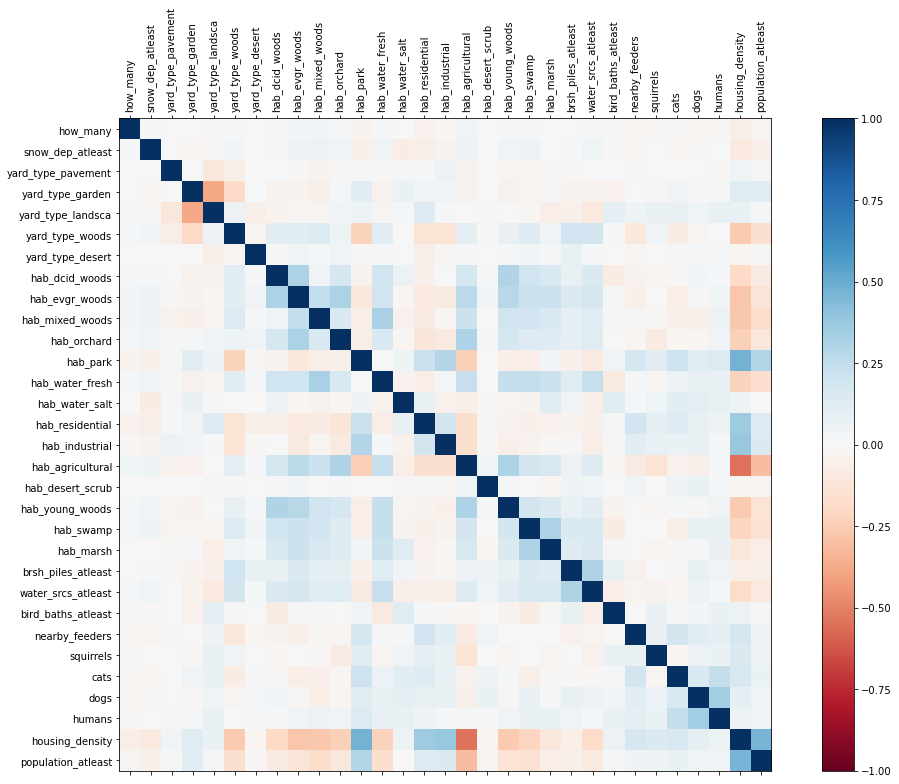

In [55]:
corr = quantitative_join_df.corr()

fig = plt.figure()
fig.set_size_inches(18, 12)
ax = fig.add_subplot() 
fig.colorbar(ax.matshow(corr, cmap='RdBu', vmin=-1, vmax=1)) 

ax.set_xticks(range(len(corr.columns))) 
ax.set_xticklabels(corr.columns)
for tick in ax.get_xticklabels(): 
        tick.set_rotation(90)

ax.set_yticks(range(len(corr.columns))) 
ax.set_yticklabels(corr.columns)

plt.show()

## Part B: Taxonomic Groups in NY and Housing Density

### Data Analysis: Exploring and comparing the proportion of observations in each housing density
The `accipiter.csv` and `junco.csv` datasets are subsets of the New York zero-filled observation data for the genera *Accipiter* (soaring birds of prey) and *Junco* (small sparrows) respectively. We decided to visualize the proportional frequency distributions to see if the distribution of housing density for overall observation reports is the same as the distribution of housing density for the *Accipiter* or *Junco* observations respectively.

If these distributions look different, this may indicate that the genus is more commonly observed in a certain housing density. If so, we can then go further and Chi-Squared Goodness of Fit test. Although this may not be able to conclude the species prefers and is more common in that particular housing density level, it can say something about the observation frequency. 

In [14]:
accipiter_df = pd.read_csv('accipiter.csv')
junco_df = pd.read_csv('junco.csv')
accipiter_df['how_many_binary'] = np.where(accipiter_df['how_many']>0, 1, 0)
junco_df['how_many_binary'] = np.where(junco_df['how_many']>0, 1, 0)

accipiter_df = accipiter_df[accipiter_df['housing_density'].notna()]
junco_df = junco_df[junco_df['housing_density'].notna()]

In [32]:
def get_null_actual(df, genus):
    housing_density_freq = df['housing_density'].value_counts() # series with counts for observations with each housing density
    # list of categories mapped to by the floats in housing_density
    housing_density_categories = ["rural", "suburban/rural", "suburban", "urban"] 
    
    actual_in_p = [] # actual "in" proportion p for each housing density of this data
    null_in_p = [] # proportion p for each housing density/overall reported observations
    freq =[] # frequency count of the species for each housing density 
    
    # looping through numbers 1-4, the values in housing_density
    for i in range(1, 5): 
        # slicing dataframe into observations that were taken in sites with this housing density and observations that were taken otherwise
        in_df = df[df['housing_density'] == float(i)] # inside this housing density

        total_in_sum = df[df['how_many_binary']==1]['how_many_binary'].count() #total observations where accipiter is reported
        in_sum = in_df['how_many_binary'].sum() #total observations where accipiter is reported in this housing density 
        in_proportion = in_sum/total_in_sum #proportion of accipiters reported in this housing density in respect to all accipiter reports
        
        freq.append(in_sum)  
        actual_in_p.append(in_proportion)    
        
        # accessing the number of observations with this housing density and dividing by the total number of observations to normalize
        # aka finding proportion of this housing density relative to total house density data
        housing_proportion = housing_density_freq[float(i)] / df['how_many_binary'].count() 
        
        null_in_p.append(housing_proportion)
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4), sharey=True)
    fig.subplots_adjust(wspace=0.65)
    housing_density_categories = ["rural", "suburban/rural", " suburban", "urban"] 
    ax1.bar(housing_density_categories, null_in_p)
    ax1.title.set_text("proportion of any reports from each housing density")
    ax2.bar(housing_density_categories, actual_in_p)
    ax2.title.set_text("proportion of "+ genus+ " reports from each housing density")
    plt.show()

    return null_in_p, actual_in_p, freq

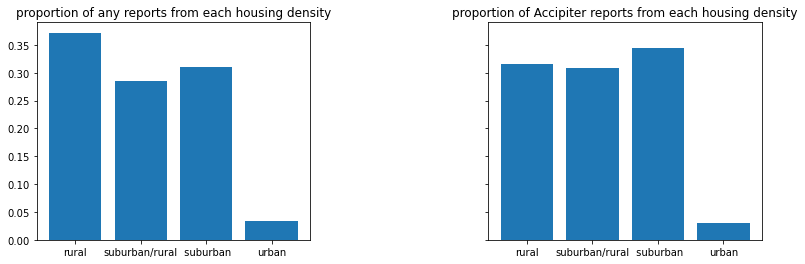

In [33]:
accipiter_null_in_p, accipiter_actual_in_p, accipiter_freq = get_null_actual(accipiter_df, "Accipiter")

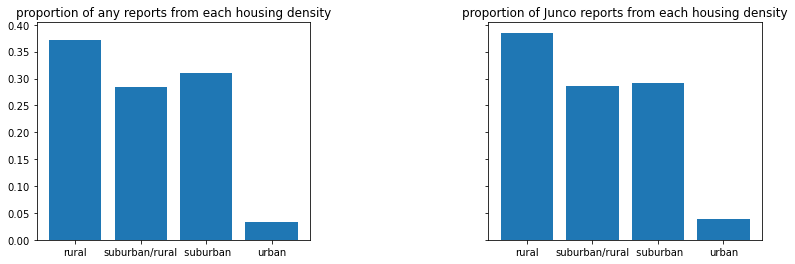

In [34]:
junco_null_in_p, junco_actual_in_p, junco_freq = get_null_actual(junco_df, "Junco")

From plotting these proportions for each housing density, it appears there are some differences between the two distributions. Particularly, the bars for the *Accipiter* genus appear to be more uniform across rural, suburban/rural, and suburban in comparison to the overall distribution of all observation report housing densities. This could indicate some preference for suburban/rural or suburban environments, since the most observation data overall is collected from rural areas but the most *Accipiter* observations occur in suburban environments. 

For the *Junco* genus, the frequency bars do somewhat match the overall observation distribution at first glance, but we want to check if the slight variation is statistically significant. The *Junco* data has more observations than the *Accipiter* data, so although the difference in proportions may be small, it may be off by a larger count factor, which we want to investigate.

### Evaluation of Significance: *Accipiter* and *Junco* Chi-Square Goodness of Fit Test 
As a result of observing some differences between the proportions of all observation locations' housing densities versus the proportions of *Accipiter* and *Junco* observation locations' housing densities, the next step is to evaluate whether this difference is statistically significant or not.

The Chi-Squared Goodness of Fit test, a type of hypothesis test, can help us do this. This test helps determine whether our sample data is likely to have come from our theoretical distribution and can be used because we have counts of observations for categorical variables representing the different types of housing density. [[Source]](https://www.jmp.com/en_sg/statistics-knowledge-portal/chi-square-test/chi-square-goodness-of-fit-test.html)

We would like to check whether our observed distribution of *Accipiter*/*Junco* observations are likely to have come from our overall distribution of all observation reports' housing densities or not.  

In [19]:
import numpy as np
import scipy.stats as stats
from scipy.stats import chisquare

In [20]:
##https://stackoverflow.com/questions/9330114/chi-squared-test-in-python
##https://www.statology.org/chi-square-goodness-of-fit-test-python/
##https://www.jmp.com/en_sg/statistics-knowledge-portal/chi-square-test/chi-square-goodness-of-fit-test.html

observed = accipiter_freq
print("frequency of accipiters in each housing density:", observed)
expected = np.array(accipiter_null_in_p) * np.sum(observed)
print("expected frequency of accipiters in each housing density:", expected)

chisquare(observed, expected)

frequency of accipiters in each housing density: [3132, 3069, 3425, 296]
expected frequency of accipiters in each housing density: [3689.57909085 2824.63737037 3070.76422789  337.01931089]


Power_divergenceResult(statistic=151.25924800617014, pvalue=1.4096649615280945e-32)

The result of performing a Chi-Squared Goodness of Fit test to compare the *Accipiter* observation housing densities to the overall observation housing densities has resulting in an extremly small p-value < 0.05, thus we can reject the null hypothesis.

In [35]:
observed = junco_freq
print("frequency of juncos in each housing density:", observed)
expected = np.array(junco_null_in_p) * np.sum(observed)
print("expected frequency of juncos in each housing density:", expected)

chisquare(observed, expected)

frequency of juncos in each housing density: [29685, 21984, 22428, 2963]
expected frequency of juncos in each housing density: [28655.40866166 21937.77018348 23849.33394491  2617.48720995]


Power_divergenceResult(statistic=167.40536354834228, pvalue=4.6215041195555774e-36)

The result of performing a Chi-Squared Goodness of Fit test to compare the *Junco* observation housing densities to the overall observation housing densities has resulting in an extremly small p-value < 0.05, thus we can reject the null hypothesis.

### *Accipiter* and *Junco* Chi-Square Goodness of Fit:
### Interpretations and Conclusion
The result of performing a Chi-Square Goodness of Fit test to compare the *Accipiter* observation housing densities to the overall observation housing densities has resulting in an extremly small p-value and large test statistic. Given we have 4 housing density categories, `scipy.stats` is able to determine this Chi-square test has 3 degrees of freedom, therefore this test statistic of 151.25 falls at the very far right end of the distirbution curve, being extremly unlikely that the sample data came from the theoretical distribution. A p-value < 0.05 is enough for us to feel comfortable rejecting the null hypothesis that the proportion of *Accipiter* observations in each habitat type is equal to the proportion of that habitat type across all observations. In conclusion, we are able to identify that birds of the *Accipiter* genus do likely have preferences of location based on housing density. 

Similarily, the *Junco* Chi-Square Goodness of Fit test has a p-value < 0.05, which allows us to reject the null hypothesis that the proportion of *Junco* observations in each habitat type is equal to the proportion of that habitat type across all observations. Although the graphs during data analysis appeared to be similar to the original distribution, the sheer amount of *Junco* data expected (20,000+ in comparison to the *Accipiter* expected 3000+), a small proportional difference corresponds to a relatively large difference in counts. In conclusion, we are able to identify that birds of the *Junco* genus do likely have preferences of location based on housing density. 

### Limitations
Because we are using observational data, unfortunately these results cannot allow us to conclude which housing density birds of the *Accipiter* or *Junco* genera prefer, but rather that the observation sample data for each genus does not match the overall proportion of observations in general of all species. There is a reasonable concern that the overall distribution of all observation reports from all species could be skewed due to other species that do have a strong preference, therefore skewing the "theoretical" or "population" distribution we are using for our Chi-Square test. However, we chose to investigate two common genera in the overall dataset and the two genera are quite distinct types of birds. Therefore we believe if any genera were to best fit the overall dataset's housing distribution, a more common genera that contributes more observations would be more likely to match. 

## Evaluation of significance
Use hypothesis tests, simulation, randomization, or
any other techniques we have learned to compare the patterns you observe in the
dataset to simple randomness.

## Interpretation and conclusions
What did you find over the course of your data
analysis, and how confident are you in these conclusions? Detail your results
more so than in the introduction, now that the reader is familiar with your
methods and analysis. Interpret these results in the wider context of the real-life
application from where your data hails.

## Source Code

**[Github repository](https://github.com/marykolbas/probable-journey)**

This Github repository has all of our ipynb files, including Phase milestones for this project, `bluejay_df.csv`, and `redpoll_df.csv` which are used in *Appendix: Other Analysis*. 

**[Cornell Box]**

This folder in Cornell Box includes all other csv files used that are too big to include on Github, including original datasets used for data cleaning (`PFW_2021_public`, `PFW-species-translation-table.csv`) and the final datasets used in the final report (`all_housing_density.csv`, `zero_filled_join.csv`, `accipiter.csv`, `junco.csv`)

**[R Code from Feederwatch](https://engagement-center.github.io/Project-FeederWatch-Zerofilling-Taxonomic-Rollup-Public/)**

This R Code was created by FeederWatch to conduct taxonomic roll-up and zero-filling, two procedures recommended by FeederWatch to limit errors. More information on how this was used can be found in *Appendix: Data Cleaning*. 

## Acknowledgments
Recognize any people or online resources that you found
helpful. These can be tutorials, software packages, Stack Overflow questions,
peers, and data sources. Showing gratitude is a great way to feel happier! But it
also has the nice side-effect of reassuring us that you're not passing off someone
else's work as your own. Crossover with other courses is permitted and
encouraged, but it must be clearly stated, and it must be obvious what parts were
and were not done for 2950. Copying without attribution robs you of the chance
to learn, and wastes our time investigating.

**Chi-Square Goodness of Fit Resources** 
- https://stackoverflow.com/questions/9330114/chi-squared-test-in-python
- https://www.statology.org/chi-square-goodness-of-fit-test-python/
- https://www.jmp.com/en_sg/statistics-knowledge-portal/chi-square-test/chi-square-goodness-of-fit-test.html
- [Debugging chisquare()](https://www.mail-archive.com/debian-bugs-rc@lists.debian.org/msg596992.html)


**Matplotlib Subplot Resources:**
- [Stack Overflow: Titling subplots](https://stackoverflow.com/questions/25239933/how-to-add-a-title-to-each-subplot)
- [Making Subplots share the same axis](https://www.skytowner.com/explore/making_subplots_share_the_same_axis_in_matplotlib)

## Questions for reviewers

1. Do you see any potentially interesting narratives in our data that we should focus on / emphasize more in further analysis?
2. Do you have concerns about our research questions being too broad or ambitious in scope?
3. Are there any logical/mathematical issues that stand out to you about how the data is currently being cleaned and manipulated?